<a href="https://colab.research.google.com/github/new5558/superai-handwritten-digit-hackathon-solution/blob/master/Super_AI_handwriting_digit_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[The Super AI Engineer 2021: Handwritten Digit competition](https://www.kaggle.com/c/super-ai-engineer-2021-handwritten-digit/overview) requires particpant to predict 1-5 digits from the images pool captured by participants themselves. We applied various technique and ultimately select [TrOCR](https://arxiv.org/abs/2109.10282) to be used in this notebook. 

Unfortunately, the competition dataset is not available publicly. **To fully use the notebook, you have to be competition's participant and change Google Drive path in the notebook to your own images storage path.**

Contributors:
- Norapat Buppodom: Modeling and Programming [![Linkedin](https://i.stack.imgur.com/gVE0j.png) LinkedIn](https://www.linkedin.com/in/norapat-buppodom/) [![GitHub](https://i.stack.imgur.com/tskMh.png) GitHub](https://github.com/new5558)
- Teeraphong Kanchanakantikul: Modeling and Visualization [🏆 Kaggle](https://github.com/new5558)

# Import depedencies

In [1]:
!git init
!git remote add origin https://github.com/new5558/superai-handwritten-digit-hackathon-solution
!git pull origin master

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/new5558/superai-handwritten-digit-hackathon-solution
 * branch            master     -> FETCH_HEAD
Already up to date.


In [2]:
!pip install -q transformers python-Levenshtein datasets imgaug

In [3]:
import numpy as np
import scipy.io
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Levenshtein import distance
import torch
from tqdm.auto import tqdm

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
def show_image_dataset(image):
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Prepare TrOCR

In [6]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests 
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten") 
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
!wget https://huggingface.co/microsoft/trocr-base-handwritten/raw/main/vocab.json

--2022-01-22 11:12:35--  https://huggingface.co/microsoft/trocr-base-handwritten/raw/main/vocab.json
Resolving huggingface.co (huggingface.co)... 34.224.55.150, 34.204.221.201, 54.205.126.93, ...
Connecting to huggingface.co (huggingface.co)|34.224.55.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898822 (878K) [application/json]
Saving to: ‘vocab.json.1’

vocab.json.1        100%[===================>] 877.76K  2.74MB/s    in 0.3s    

2022-01-22 11:12:36 (2.74 MB/s) - ‘vocab.json.1’ saved [898822/898822]



In [8]:
import json
 
# Opening JSON file
with open('vocab.json') as json_file:
    vacab_dict = json.load(json_file)

In [9]:
vacab_dict

{'<s>': 0,
 '<pad>': 1,
 '</s>': 2,
 '<unk>': 3,
 '.': 4,
 'Ġthe': 5,
 ',': 6,
 'Ġto': 7,
 'Ġand': 8,
 'Ġof': 9,
 'Ġa': 10,
 'Ġin': 11,
 '-': 12,
 'Ġfor': 13,
 'Ġthat': 14,
 'Ġon': 15,
 'Ġis': 16,
 'âĢ': 17,
 "'s": 18,
 'Ġwith': 19,
 'ĠThe': 20,
 'Ġwas': 21,
 'Ġ"': 22,
 'Ġat': 23,
 'Ġit': 24,
 'Ġas': 25,
 'Ġsaid': 26,
 'Ļ': 27,
 'Ġbe': 28,
 's': 29,
 'Ġby': 30,
 'Ġfrom': 31,
 'Ġare': 32,
 'Ġhave': 33,
 'Ġhas': 34,
 ':': 35,
 'Ġ(': 36,
 'Ġhe': 37,
 'ĠI': 38,
 'Ġhis': 39,
 'Ġwill': 40,
 'Ġan': 41,
 'Ġthis': 42,
 ')': 43,
 'ĠâĢ': 44,
 'Ġnot': 45,
 'Ŀ': 46,
 'Ġyou': 47,
 'ľ': 48,
 'Ġtheir': 49,
 'Ġor': 50,
 'Ġthey': 51,
 'Ġwe': 52,
 'Ġbut': 53,
 'Ġwho': 54,
 'Ġmore': 55,
 'Ġhad': 56,
 'Ġbeen': 57,
 'Ġwere': 58,
 'Ġabout': 59,
 ',"': 60,
 'Ġwhich': 61,
 'Ġup': 62,
 'Ġits': 63,
 'Ġcan': 64,
 'Ġone': 65,
 'Ġout': 66,
 'Ġalso': 67,
 'Ġ$': 68,
 'Ġher': 69,
 'Ġall': 70,
 'Ġafter': 71,
 '."': 72,
 '/': 73,
 'Ġwould': 74,
 "'t": 75,
 'Ġyear': 76,
 'Ġwhen': 77,
 'Ġfirst': 78,
 'Ġshe': 79,
 'Ġtwo': 

In [10]:
def num_there(s):
    return any(i.isdigit() for i in s)

In [11]:
numberic_keys = list(filter(lambda key: num_there(key), vacab_dict.keys()))
numberic_index = list(map(lambda key: vacab_dict[key], numberic_keys))

In [12]:
print(len(vacab_dict.keys()))
print(len(numberic_index))

50265
1731


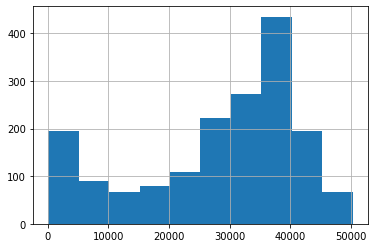

In [13]:
pd.Series(numberic_index).hist()

In [14]:
# Get text fron TrOCR model
def get_text_transformeres(image):
  pixel_values = processor(image, return_tensors="pt").pixel_values
  pixel_values_tensor = torch.tensor(pixel_values).cuda()
  
  generated_ids = model.generate(pixel_values_tensor)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_text


In [15]:
# Get text from modified TrOCR model that normalize text without digit output token probability to be zero
def get_text_transformeres_numeric(image, numeric_index):
  pixel_values = processor(image, return_tensors="pt").pixel_values
  pixel_values_tensor = torch.tensor(pixel_values).cuda()
  
  result_generated = model.generate(pixel_values_tensor, return_dict_in_generate=True, output_scores=True)
  numeric_index_copy = [2, *numeric_index] # '2' is a special token that we must keep. We concat 2 with token that contains nemeric text (numeric_index)

  torch_generated_scores = torch.stack(result_generated['scores'])
  torch_generated_scores = torch_generated_scores.view((torch_generated_scores.shape[0], torch_generated_scores.shape[2])) # Reshape scores
  selected_scores = torch_generated_scores[:,numeric_index_copy] # Normalize non-digit tokens probability
  argmax = torch.argmax(selected_scores, dim = 1).cpu().detach().numpy() # Select highest probability tokens
  
  new_result = np.array(numeric_index_copy)[argmax][None]
  
  generated_text = processor.batch_decode(new_result, skip_special_tokens=True)[0]
  return generated_text

In [16]:
def filter_number(text):
  """
  Filter characters and spaces out from text
  """
  numeric_filter = filter(str.isdigit, text)
  return "".join(numeric_filter)

In [17]:
def filter_number_2(text):
  """
  1. Group text by spaces as divider. 
  2. Filter characters and spaces out from text from each group. 
  3. Select only longest group
  """
  text_split = text.split(" ")
  results = []
  for text in text_split:
    numeric_filter = filter(str.isdigit, text)
    result = "".join(numeric_filter)
    if result.strip() != "":
      results.append(result)

  if len(results) == 0:
    return ""
  
  return max(results, key=len)

In [18]:
filter_number('1 2 3334. 324ojk dsjfkhdf kl 234234.   ')

'123334324234234'

In [19]:
filter_number_2('1 2 3334. 324ojk dsjfkhdf kl 234234.   ')

'234234'

In [20]:
distance('test', 'test3')

1

# ARDIS dataset

## Download dataset - Part 1 and Part 2
https://ardisdataset.github.io/ARDIS/

In [21]:
!wget https://raw.githubusercontent.com/ardisdataset/ARDIS//Updates-Date-String/Date%20Strings%20Part%20I.zip

--2022-01-22 10:34:06--  https://raw.githubusercontent.com/ardisdataset/ARDIS//Updates-Date-String/Date%20Strings%20Part%20I.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /ardisdataset/ARDIS/Updates-Date-String/Date%20Strings%20Part%20I.zip [following]
--2022-01-22 10:34:06--  https://raw.githubusercontent.com/ardisdataset/ARDIS/Updates-Date-String/Date%20Strings%20Part%20I.zip
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 18962345 (18M) [application/zip]
Saving to: ‘Date Strings Part I.zip’

Date Strings Part I 100%[===================>]  18.08M  --.-KB/s    in 0.08s   

2022-01-22 10:34:07 (224 MB/s) - ‘Date Strings Part I.zip’ saved [18962345/18962345]



In [22]:
!wget https://raw.githubusercontent.com/ardisdataset/ARDIS/master/ARDIS_DATASET_II.rar

--2022-01-22 10:34:07--  https://raw.githubusercontent.com/ardisdataset/ARDIS/master/ARDIS_DATASET_II.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7863462 (7.5M) [application/octet-stream]
Saving to: ‘ARDIS_DATASET_II.rar’

ARDIS_DATASET_II.ra 100%[===================>]   7.50M  --.-KB/s    in 0.06s   

2022-01-22 10:34:08 (131 MB/s) - ‘ARDIS_DATASET_II.rar’ saved [7863462/7863462]



In [23]:
!unzip "Date Strings Part I.zip"

Archive:  Date Strings Part I.zip
   creating: Part I/
  inflating: Part I.xlsx             
  inflating: Part I/T_v120849.b1990.s192.jpg  
  inflating: Part I/T_v120849.b2340.s227.jpg  
  inflating: Part I/T_v120849.b2690.s262.jpg  
  inflating: Part I/T_v120849.b3010.s294.jpg  
  inflating: Part I/T_v120849.b390.s33.jpg  
  inflating: Part I/T_v120849.b70.s1.jpg  
  inflating: Part I/T_v120854.b1020.s92.jpg  
  inflating: Part I/T_v120854.b1100.s100.jpg  
  inflating: Part I/T_v120854.b1160.s106.jpg  
  inflating: Part I/T_v120854.b1230.s113.jpg  
  inflating: Part I/T_v120854.b1300.s120.jpg  
  inflating: Part I/T_v120854.b1360.s126.jpg  
  inflating: Part I/T_v120854.b1400.s130.jpg  
  inflating: Part I/T_v120854.b1500.s138.jpg  
  inflating: Part I/T_v120854.b170.s9.jpg  
  inflating: Part I/T_v120854.b220.s14.jpg  
  inflating: Part I/T_v120854.b280.s20.jpg  
  inflating: Part I/T_v120854.b340.s26.jpg  
  inflating: Part I/T_v120854.b430.s33.jpg  
  inflating: Part I/T_v120854.b5

In [24]:
!unrar x ARDIS_DATASET_II.rar

Streaming output truncated to the last 5000 lines.
Extracting  ARDIS_DATASET_II/3/394.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/395.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/396.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/397.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/398.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/399.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/4.jpg                                      31%  OK 
Extracting  ARDIS_DATASET_II/3/40.jpg                                     31%  OK 
Extracting  ARDIS_DATASET_II/3/400.jpg                                    31%  OK 
Extracting  ARDIS_DATASET_II/3/401.jpg                                    32%  OK 
Extracting  ARDIS_DATASET_II/

## Dataset I

### Get image from path

In [25]:
ex_df = pd.read_excel('Part I.xlsx')

In [26]:
ex_df

,Image_Left,Image_Right,City,Date,Category
0,v120849.b1210.s114,NaN,Alnö,1900,Födda
1,v120849.b1600.s153,NaN,Alnö,1901,Födda
2,v120849.b1990.s192,T_v120849.b1990.s192,Alnö,1902,Födda
3,v120849.b2340.s227,T_v120849.b2340.s227,Alnö,1903,Födda
4,v120849.b2690.s262,T_v120849.b2690.s262,Alnö,1904,Födda
...,...,...,...,...,...
2543,v214662.b680.s64,NaN,Sävar,1919,Döda
2544,v214662.b740.s70,NaN,Sävar,1920,Döda
2545,v214662.b800.s76,NaN,Sävar,1921,Döda
2546,v214662.b930.s89,NaN,Sävar,1923,Döda


In [27]:
ex_df['Image_Left'].isna().value_counts()

False    2548
Name: Image_Left, dtype: int64

In [28]:
ex_df['Image_Right'].isna().value_counts()

False    1429
True     1119
Name: Image_Right, dtype: int64

In [29]:
from tqdm.auto import tqdm

In [30]:
# We decided to read Image_left because Image_right contains lot of NaN
images_ardis = []
images_ardis_label = []
for i, row in tqdm(ex_df.iterrows(), total=ex_df.shape[0]):
  img_path = row['Image_Left']
  image = cv2.imread(f'./Part I/{img_path}.jpg')
  images_ardis.append(image)
  images_ardis_label.append(row['Date'])

  0%|          | 0/2548 [00:00<?, ?it/s]

In [31]:
images_ardis = np.array(images_ardis)
images_ardis_label = np.array(images_ardis_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [32]:
images_ardis.shape

(2548,)

In [33]:
images_ardis_label

array([1900, 1901, 1902, ..., 1921, 1923, 1924])

In [34]:
images_ardis

array([array([[[126, 178, 184],
        [127, 179, 185],
        [127, 179, 185],
        ...,
        [136, 184, 190],
        [136, 184, 190],
        [137, 185, 191]],

       [[128, 180, 186],
        [128, 180, 186],
        [129, 181, 187],
        ...,
        [136, 184, 190],
        [136, 184, 190],
        [137, 185, 191]],

       [[131, 181, 187],
        [131, 181, 187],
        [132, 182, 188],
        ...,
        [136, 184, 190],
        [137, 185, 191],
        [137, 185, 191]],

       ...,

       [[134, 179, 190],
        [133, 178, 189],
        [132, 178, 189],
        ...,
        [135, 183, 185],
        [135, 182, 186],
        [135, 183, 185]],

       [[134, 179, 190],
        [133, 178, 189],
        [132, 178, 189],
        ...,
        [135, 184, 186],
        [134, 183, 185],
        [134, 183, 185]],

       [[134, 179, 190],
        [133, 178, 189],
        [132, 178, 189],
        ...,
        [137, 186, 188],
        [136, 185, 187],
        [135, 184

### EDA

In [35]:
ratios = []

for image in images_ardis:
  ratio = image.shape[0]/image.shape[1]
  ratios.append(ratio)

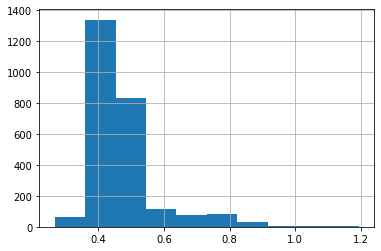

In [36]:
# Explore image ratio distribution
pd.Series(ratios).hist()

### Preprocess data

In [37]:
test_data = cv2.imread('./Part I/v120849.b2690.s262.jpg')
test_data2 = cv2.imread('./Part I/T_v120849.b2690.s262.jpg')

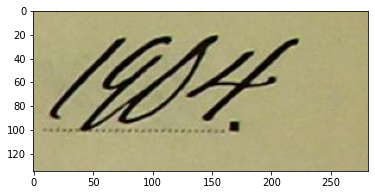

In [38]:
# Original
show_image_dataset(test_data)

In [39]:
# Try GuassianBlur -> Convert RGB to Grayscale -> OTSU Thresold -> Convert back to RGB
blur = cv2.GaussianBlur(test_data,(5,5),0)
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY) # Convert RGB to Grayscale
ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Thresold
threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB) # Convert picture back to RGB to be compatible with TrOCR model

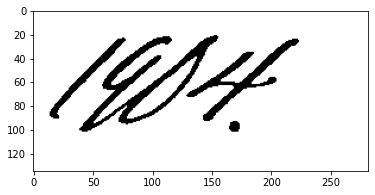

In [40]:
show_image_dataset(threshrgb)

In [41]:
images_white_ardis = []
for image in tqdm(images_ardis):
  blur = cv2.GaussianBlur(image,(5,5),0)
  img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
  threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
  images_white_ardis.append(threshrgb)

images_white_ardis = np.array(images_white_ardis)

  0%|          | 0/2548 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [42]:
images_white_ardis.shape

(2548,)

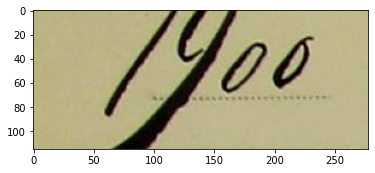

In [43]:
show_image_dataset(images_ardis[0])

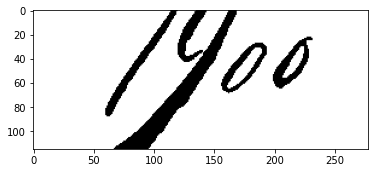

In [44]:
show_image_dataset(images_white_ardis[0])

### Try transformers OCR from Huggingface - TrOCR



#### Predict from images

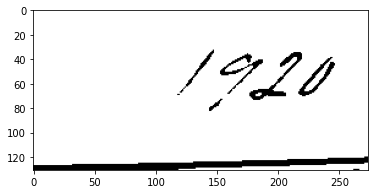

In [45]:
show_image_dataset(images_white_ardis[200])

In [46]:
get_text_transformeres_numeric(images_white_ardis[200], numberic_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'0 1 1920 920'

In [47]:
get_text_transformeres(images_white_ardis[200])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'0 1/ 920'

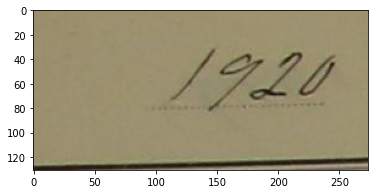

In [48]:
show_image_dataset(images_ardis[200])

In [49]:
get_text_transformeres(images_ardis[200])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'1920'

In [50]:
get_text_transformeres_numeric(images_ardis[200], numberic_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'1920'

#### Evaluate raw images

In [51]:
images_ardis_train, images_ardis_test, images_ardis_label_train, images_ardis_label_test = train_test_split(images_ardis, images_ardis_label, test_size = 0.1, random_state = 42)

In [52]:
result_distances = []
for i in tqdm(range(len(images_ardis_test))):
  image = images_ardis_test[i]
  label = str(images_ardis_label_test[i])
  pred_text = get_text_transformeres(image)
  pred_text_clean = filter_number(pred_text)
  result_distance = distance(pred_text_clean, label)
  result_distances.append(result_distance)

  0%|          | 0/255 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


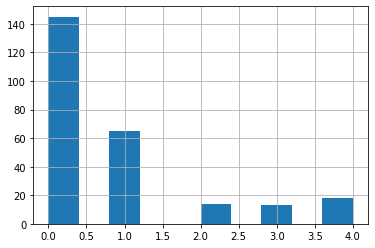

In [53]:
pd.Series(result_distances).hist()

In [54]:
sum(result_distances) / len(result_distances)

0.8

#### Evaluate preprocessed image

In [55]:
images_white_ardis_train, images_white_ardis_test, images_white_ardis_label_train, images_white_ardis_label_test = train_test_split(images_white_ardis, images_ardis_label, test_size = 0.1, random_state = 42)

In [56]:
result_distances = []
pred_texts = []
pred_text_cleans = []
for i in tqdm(range(len(images_white_ardis_test))):
  image = images_white_ardis_test[i]
  label = str(images_white_ardis_label_test[i])
  pred_text = get_text_transformeres(image)
  pred_text_clean = filter_number_2(pred_text)
  result_distance = distance(pred_text_clean, label)
  
  result_distances.append(result_distance)
  pred_texts.append(pred_text)
  pred_text_cleans.append(pred_text_clean)

  0%|          | 0/255 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


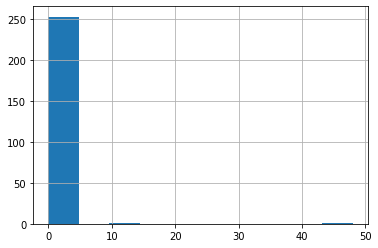

In [57]:
pd.Series(result_distances).hist()

In [58]:
sum(result_distances) / len(result_distances)

1.011764705882353

##### Error analysis

In [81]:
result_distances_array = np.array(result_distances)
false_index_one = np.where(result_distances_array == 4)[0]
false_index_one

array([ 23,  25,  27,  33,  34,  41,  50,  51,  71,  85,  96, 114, 160,
       239])

In [82]:
error_anslysis_index = false_index_one[9]

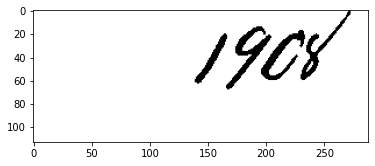

In [83]:
show_image_dataset(images_white_ardis_test[error_anslysis_index])

In [84]:
print(pred_texts[error_anslysis_index])
print(pred_text_cleans[error_anslysis_index])
print(images_white_ardis_label_test[error_anslysis_index])

2 1,..... 1 9. 0.
2
1908


_____

In [85]:
false_index_two = np.where(result_distances_array == 2)

In [86]:
error_anslysis_index = false_index_two[0][15]

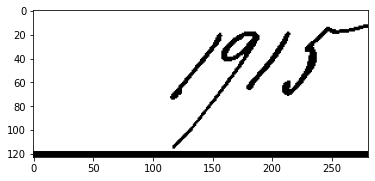

In [87]:
show_image_dataset(images_white_ardis_test[error_anslysis_index])

In [88]:
print(pred_texts[error_anslysis_index])
print(pred_text_cleans[error_anslysis_index])
print(images_white_ardis_label_test[error_anslysis_index])

. 1915..15
191515
1915


#### Evaluate preprocessed image - numeric only

In [89]:
images_white_ardis_train, images_white_ardis_test, images_white_ardis_label_train, images_white_ardis_label_test = train_test_split(images_white_ardis, images_ardis_label, test_size = 0.1, random_state = 42)

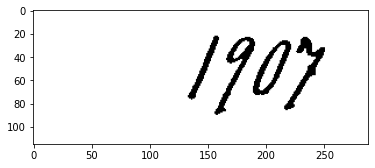

In [90]:
show_image_dataset(images_white_ardis_test[0])

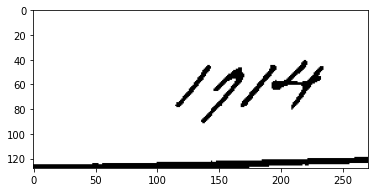

In [91]:
show_image_dataset(images_white_ardis_test[1])

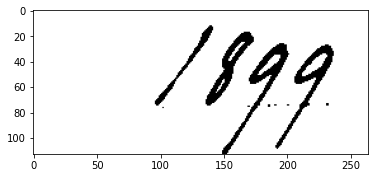

In [92]:
show_image_dataset(images_white_ardis_test[2])

In [93]:
result_distances = []
pred_texts = []
pred_text_cleans = []
for i in tqdm(range(len(images_white_ardis_test))):
  image = images_white_ardis_test[i]
  label = str(images_white_ardis_label_test[i])
  pred_text = get_text_transformeres_numeric(image, numberic_index)
  pred_text_clean = filter_number(pred_text)
  result_distance = distance(pred_text_clean, label)
  
  result_distances.append(result_distance)
  pred_texts.append(pred_text)
  pred_text_cleans.append(pred_text_clean)

  0%|          | 0/255 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


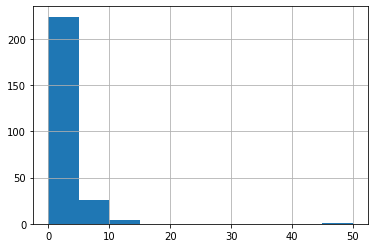

In [94]:
pd.Series(result_distances).hist()

In [95]:
sum(result_distances) / len(result_distances)

2.407843137254902

##### Error analysis

In [96]:
result_distances_array = np.array(result_distances)
false_index_one = np.where(result_distances_array == 4)[0]
false_index_one

array([  2,   9,  18,  31,  50,  60,  69,  76, 102, 115, 134, 145, 160,
       184, 185, 209, 224, 239])

In [97]:
error_anslysis_index = false_index_one[10]

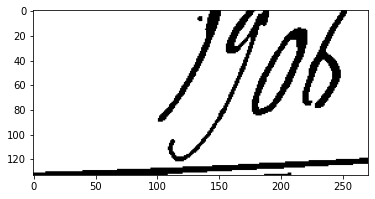

In [98]:
show_image_dataset(images_white_ardis_test[error_anslysis_index])

In [99]:
print(pred_texts[error_anslysis_index])
print(pred_text_cleans[error_anslysis_index])
print(images_white_ardis_label_test[error_anslysis_index])

2 790695
2790695
1906


_____

In [100]:
false_index_two = np.where(result_distances_array == 2)[0]
false_index_two

array([  3,  12,  16,  23,  34,  36,  43,  51,  57,  65,  66,  68,  82,
        84,  86,  96, 116, 118, 132, 137, 141, 142, 157, 164, 176, 183,
       188, 199, 203, 221, 233, 235, 240, 246])

In [101]:
error_anslysis_index = false_index_two[15]

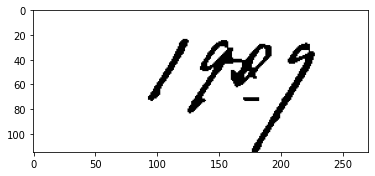

In [102]:
show_image_dataset(images_white_ardis_test[error_anslysis_index])

In [103]:
print(pred_texts[error_anslysis_index])
print(pred_text_cleans[error_anslysis_index])
print(images_white_ardis_label_test[error_anslysis_index])

4 1 99
4199
1909


## Dataset II

In [104]:
import os

data_folder = './ARDIS_DATASET_II'

images_digit = []
images_digit_label = []

for folder in os.listdir(data_folder):
  label = folder
  for file_name in os.listdir(f'./ARDIS_DATASET_II/{folder}'):
    path = f'./ARDIS_DATASET_II/{folder}/{file_name}'
    image = cv2.imread(path)
    image = cv2.resize(image, (32, 32))

    images_digit.append(image)
    images_digit_label.append(label)

In [105]:
images_digit = np.array(images_digit)
images_digit_label = np.array(images_digit_label)

In [106]:
images_digit.shape

(7602, 32, 32, 3)

In [107]:
images_digit_label.shape

(7602,)

In [108]:
images_digit_label

array(['3', '3', '3', ..., '5', '5', '5'], dtype='<U1')

In [109]:
images_digit_label[10]

'3'

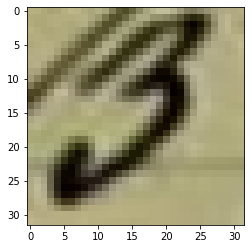

In [125]:
show_image_dataset(images_digit[10])

In [111]:
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
# define example
data = array(images_digit_label)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)

['3' '3' '3' ... '5' '5' '5']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3


In [112]:
encoded.shape

(7602, 10)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(images_digit , encoded, test_size=0.1)

In [114]:
x_train.shape

(6841, 32, 32, 3)

In [115]:
y_train.shape

(6841, 10)

In [116]:
x_test.shape

(761, 32, 32, 3)

In [117]:
y_test.shape

(761, 10)

In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=[0.8,1.2]
    )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=256,)

validation_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=256,)

In [119]:
from tensorflow.keras.applications import VGG16 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten

vgg16 = VGG16( 
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3)
)

model_vgg = Sequential()
model_vgg.add(vgg16)
model_vgg.add(Flatten())
model_vgg.add(Dense(10, activation = 'softmax'))

# for layer in efficient_net.layers:
# #     print(layer)
#     layer.trainable = False

model_vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [120]:
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
model_vgg.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [121]:
model_vgg.fit(train_generator, epochs=10, validation_data = validation_generator)

Epoch 1/10
27/27 [==============================] - 14s 176ms/step - loss: 2.8927 - accuracy: 0.0943 - val_loss: 2.3027 - val_accuracy: 0.1367
Epoch 2/10
27/27 [==============================] - 3s 115ms/step - loss: 2.2610 - accuracy: 0.1491 - val_loss: 2.0165 - val_accuracy: 0.2484
Epoch 3/10
27/27 [==============================] - 3s 113ms/step - loss: 1.9007 - accuracy: 0.2909 - val_loss: 1.9787 - val_accuracy: 0.2129
Epoch 4/10
27/27 [==============================] - 3s 114ms/step - loss: 1.7167 - accuracy: 0.3410 - val_loss: 1.3178 - val_accuracy: 0.4731
Epoch 5/10
27/27 [==============================] - 3s 114ms/step - loss: 1.3862 - accuracy: 0.4559 - val_loss: 1.1243 - val_accuracy: 0.5703
Epoch 6/10
27/27 [==============================] - 3s 115ms/step - loss: 1.1392 - accuracy: 0.5670 - val_loss: 0.6763 - val_accuracy: 0.7569
Epoch 7/10
27/27 [==============================] - 3s 115ms/step - loss: 0.8303 - accuracy: 0.7049 - val_loss: 0.5023 - val_accuracy: 0.8423
Epoch

In [ ]:
"""Uncomment if you want to clear GPU memory from Keras model"""

# import gc
# from keras import backend as K
# del model_vgg
# K.clear_session()
# gc.collect()

In [122]:
np.argmax(model_vgg.predict(x_test[10][None]))

5

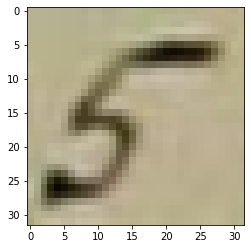

In [123]:
show_image_dataset(x_test[10])

# ORAND dataset
https://www.orand.cl/icfhr2014-hdsr/

In [21]:
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz

--2022-01-22 11:12:36--  https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz
Resolving www.orand.cl (www.orand.cl)... 162.241.225.60
Connecting to www.orand.cl (www.orand.cl)|162.241.225.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203530245 (194M) [application/x-gzip]
Saving to: ‘ORAND-CAR-2014.tar.gz.1’

ORAND-CAR-2014.tar. 100%[===================>] 194.10M  5.89MB/s    in 16s     

2022-01-22 11:12:53 (12.2 MB/s) - ‘ORAND-CAR-2014.tar.gz.1’ saved [203530245/203530245]



In [22]:
!tar -xf ORAND-CAR-2014.tar.gz

In [23]:
dataset_path = "./ORAND-CAR-2014/CAR-A/a_test_images"

In [24]:
f = open("./ORAND-CAR-2014/CAR-A/a_test_gt.txt", "r")
image_path_file = f.read()

In [25]:
image_path_s = np.array(list(map(lambda x: x.split('\t'), image_path_file.split('\n')[:-1])))

In [26]:
car_images_paths = image_path_s[:,0]
car_images_labels = image_path_s[:,1]

In [27]:
import os
import cv2
import regex

orand_images = []
orand_labels = []


for i in tqdm(range(len(car_images_paths))):
  img_path = car_images_paths[i]
  image = None

  image = cv2.imread(f"{dataset_path}/{img_path}")


  label =  car_images_labels[i]
  orand_labels.append(label)
  orand_images.append(image)

  0%|          | 0/3784 [00:00<?, ?it/s]

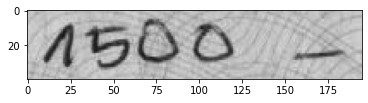

In [28]:
show_image_dataset(orand_images[0])

# Competition testset

### List data

In [29]:
!ls drive/MyDrive/SmallTest

00700310666e007443e58fb5361bda30.jpg   897d266a963661d9bf56dcd4046fb6d5.jpeg
07be2bf533df6bfb6cbdc7a9dda6a1e7.jpg   8bd7df6da60a6ad6ff121d8dd00f19e7.png
0845d50182053845f944200763a24db0.jpg   8c5f97c8e179d3dce6bc14c152ae424c.jpg
086ccb440e8b74f5f2a7713e0a07bd36.png   8c9b9f564ea5d0d71503a5e3080bd8d4.jpg
0877d414c880ab9869f894572ef8d18d.jpg   8dde29cc9ec735298cd1517a6308df59.png
0c70bcc07a8ad66aab1c02da089e5bd0.png   90612e0f9b4447ad67ba60a4c04aa8ce.png
0ecd53702e234cbe43f2fb54bc776b3d.png   90e339e55ac4cd968a05ba032584e44e.jpg
0ee2bd42ce02e0fb702617f63173f5b1.png   912616c574f60e7cebaadae459ba9a1b.png
10adae59450cdfd7333f0d5bf6de52b3.jpeg  94183b5916de1e5357c2068248867920.jpg
11fa7518389d111586e05d866bf6dc14.jpeg  94764e5ec82141b2121b277c4fa044f4.jpg
157ca8516cd8971b492ad3ac99c99c89.png   986a97e7e06ecfb8a0ce4c49f930b2ec.png
162aea31f354dd1fcbeefcd4923ba745.jpeg  98becf05d75363a3f3a63f7c438d6786.png
16cb6b3722c27a0556f84b109e12fa3e.jpg   9900c9d16782e20c1097a94fafa77fee.png
1784e6a1b44

In [30]:
!ls drive/MyDrive/TestSet1

000dd8f151c221da6bf4236cacf66d73.jpeg  8cf3be620c31f9045d60c83c9ff2681e.jpg
00390a98255151cb851161b87a302413.png   8d03ac3a1f58bf5a2553a533a38d20a1.jpg
00b2c4ea8a313583a6e1be0ab95fa6ef.png   8d05eff4372d1004078006388c28efbe.jpg
01434368c887aa65b6a1b050f53b6501.jpg   8d39b4a3d407025625ae467456258227.jpg
03d1e8539f0bdfecccd572969cfc8dbf.png   8d692515108ea7f823fa6cf5771dfe30.png
03f68cfe16cc1ab219be35bffa9765df.jpg   8e090e4e11b8a5979709f2f4684d25c9.jpg
0423ee4370faae38d6278baab3d1fd2d.png   8e222ea094cc92d802741aa8c386e934.png
0445aeaf84845e1d357b486a783f604f.png   8f1fe6837b7c9a129351a428686e9a2a.png
04d43b20cec37483660db9465fbf199a.jpg   8f2224a6311de011f0af1ca368586612.png
05af9789047aa49e3e8aba74a87d5c00.png   8f430123bb6f91ea2c6ad7b620d6de2f.jpg
06923f51ff7e352a8e8eda20a7e4e60e.jpg   8f51b0cc3da0853108658885c2842707.png
06d675f9e74f3cb1e981df6b20393ef3.jpg   8f7ad7d7e7e471984cadc4c234234d4f.png
06da6c71861309e84c5d6754af1d8328.png   905f567bc5400f156a5530fd1b28c078.jpg
07584453c962

In [31]:
!ls drive/MyDrive/TestSet2

004c1ebd789f053fa997bbb7251da1f9.png   83f948e708a5076956a38e3d652f494f.jpg
004d54be0db9e3fc021c95724b7c2b0d.png   8408751ce1181558cf9e533d7dc041ee.png
007925a67659870be7b2f2c461df8368.jpg   840a6494e7b33d708c4b0ad1ebccb9c2.jpg
007e62ad36ae31f8cd7c5ded1a70a0e4.png   8411ed5f9c7c9af32c4a8f98c1586a39.jpg
008190b4cf2391510796fda7a27d7687.jpg   8418d7bced78b88a92f92cc754eec3e3.png
0086e76a421857d34cc1ae4b941c564e.jpeg  842d6512ba93b418fb27146dca463c4c.jpeg
00874491ad4ab79ba5bc5b7a4df1e59e.jpg   844078ba9c3792f2b03304ff47a06c73.jpg
008daab67f96b475aa6a3d31c5478f7e.png   8446e9270c7fe57210f4fae7c03498e7.jpg
00b5becf236fe77f06602fe9e856e8a9.png   84799102250bdbaf281a9a6e582ffbd8.png
00f315a4b714ac515add273a408adc05.png   851f4bafc40cec102f47678e236c13ec.png
0121ccaad3507e92b8ea4e67f93ddd76.png   85301b489b11fd02848f30bc27d4e494.png
012f591f17f4226bdb3caa90f6cb3474.jpeg  85663922d352c472cd0fcfb632273dc8.png
014aa1ddec3678fb1adf2449121b11af.jpg   85ba936a8192f984804b91a611b93c1a.png
01ce75ec4a4

### Load CSV

In [32]:
csv = pd.read_csv("drive/MyDrive/sample_submission.csv")

In [33]:
csv

,Id,Predicted
0,1a4545ae6128dab578f90fb22b55758a,6152.0
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917.0
2,e297ec8d07a7b8b96c4ae16236d3b442,2462.0
3,f34c7b3405df590f88d4cf7b046ebed6,38714.0
4,629ab866836150706a45ee0e9108697a,16.0
...,...,...
2165,317aa1f54519e65ce1e3855346e7bad4,NaN
2166,b5a3b8d297a574e4406bd11fd5b6ec24,NaN
2167,399434b91e74cb5211c5ea1a301f431a,NaN
2168,17c2c6feeea11a7779d21e6f99b7b714,NaN


In [34]:
ids = csv['Id']

In [35]:
ids 

0       1a4545ae6128dab578f90fb22b55758a
1       1bc5d2ff9a7e9fdbff5f2f68f42ff64e
2       e297ec8d07a7b8b96c4ae16236d3b442
3       f34c7b3405df590f88d4cf7b046ebed6
4       629ab866836150706a45ee0e9108697a
                      ...               
2165    317aa1f54519e65ce1e3855346e7bad4
2166    b5a3b8d297a574e4406bd11fd5b6ec24
2167    399434b91e74cb5211c5ea1a301f431a
2168    17c2c6feeea11a7779d21e6f99b7b714
2169    43b3aa6e4deda0957de2aea0ada373f5
Name: Id, Length: 2170, dtype: object

In [36]:
labels_csv = pd.read_csv("labels.csv", index_col = 0, dtype = {'Id': str, 'label': str})

In [37]:
labels_csv

,Id,label
0,1a4545ae6128dab578f90fb22b55758a,6152
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917
2,e297ec8d07a7b8b96c4ae16236d3b442,2462
3,f34c7b3405df590f88d4cf7b046ebed6,38714
4,629ab866836150706a45ee0e9108697a,1674
...,...,...
2165,317aa1f54519e65ce1e3855346e7bad4,NaN
2166,b5a3b8d297a574e4406bd11fd5b6ec24,NaN
2167,399434b91e74cb5211c5ea1a301f431a,NaN
2168,17c2c6feeea11a7779d21e6f99b7b714,NaN


In [38]:
csv = pd.merge(csv, labels_csv, on='Id', how='left')

In [39]:
csv

,Id,Predicted,label
0,1a4545ae6128dab578f90fb22b55758a,6152.0,6152
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917.0,87917
2,e297ec8d07a7b8b96c4ae16236d3b442,2462.0,2462
3,f34c7b3405df590f88d4cf7b046ebed6,38714.0,38714
4,629ab866836150706a45ee0e9108697a,16.0,1674
...,...,...,...
2165,317aa1f54519e65ce1e3855346e7bad4,NaN,NaN
2166,b5a3b8d297a574e4406bd11fd5b6ec24,NaN,NaN
2167,399434b91e74cb5211c5ea1a301f431a,NaN,NaN
2168,17c2c6feeea11a7779d21e6f99b7b714,NaN,NaN


In [40]:
len(csv) - csv['label'].isna().sum()

870

### Load image

In [41]:
import os

small_test_dataset_path = "drive/MyDrive/SmallTest"
test_one_dataset_path = "drive/MyDrive/TestSet1"
test_one_dataset_path2 = "drive/MyDrive/TestSet2"

os.environ['OPENCV_IO_ENABLE_JASPER'] = 'true'
os.environ['OPENCV_IO_ENABLE_JASPER'] = '1'

In [42]:
len(os.listdir(small_test_dataset_path))

220

In [43]:
paths1 = os.listdir(small_test_dataset_path)
paths2 = os.listdir(test_one_dataset_path)
paths3 = os.listdir(test_one_dataset_path2)

paths = [*paths1, *paths2, *paths3]
# paths = [*paths1, *paths2]
paths_splited = list(map(lambda path: path.split('.'), paths))
paths_splited = np.array(paths_splited)

In [44]:
len(paths)

2170

In [45]:
paths_cleaned = paths_splited[:,0]

In [46]:
import os
import cv2
import regex

superai_images = []
superai_labels = []

img_paths_read = []

for i in tqdm(range(len(ids))):
  img_path = ids[i]
  index_path = np.where(paths_cleaned == img_path)
  image = None
  
  if len(index_path[0]) != 0:
    img_path_full = paths[index_path[0][0]]

    image = cv2.imread(f"{test_one_dataset_path2}/{img_path_full}")
    if image is None:
      image = cv2.imread(f"{test_one_dataset_path}/{img_path_full}")
    if image is None:
      image = cv2.imread(f"{small_test_dataset_path}/{img_path_full}")


  label =  csv[csv['Id'] == img_path]['label'].iloc[0]
  superai_labels.append(label)
  img_paths_read.append(img_path)
  
  superai_images.append(image)

  0%|          | 0/2170 [00:00<?, ?it/s]

In [47]:
len(img_paths_read)

2170

In [48]:
img_paths_read[0]

'1a4545ae6128dab578f90fb22b55758a'

In [49]:
len(superai_images)

2170

In [50]:
superai_images = np.array(superai_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [51]:
print(superai_images.shape)

(2170,)


In [52]:
ratios = []

for image in superai_images:
  if image is not None:
    ratio = image.shape[0]/image.shape[1]
    ratios.append(ratio)

In [53]:
len(ratios)

2170

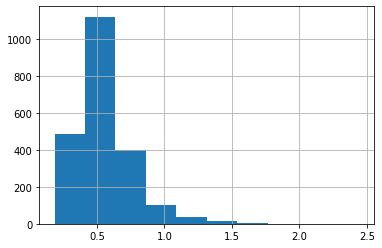

In [54]:
pd.Series(ratios).hist()

In [55]:
test_data = superai_images[0]
test_data.shape

(106, 196, 3)

## Export images

In [56]:
# for i in range(len(superai_images)):
#   image = superai_images[i]
#   if image is not None:
#     path = img_paths_read[i]
#     cv2.imwrite(f'drive/MyDrive/test_one_and_small/{i}__{path}.jpg', image)

## Preprocess

### Basic preprocessing

In [57]:
# Preprocess using sobel edges detection

import cv2

img = test_data
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) #
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(edges,kernel,iterations = 3)
erosion = cv2.erode(dilation,kernel,iterations = 3)
dilation = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)

erosion = (255-dilation)

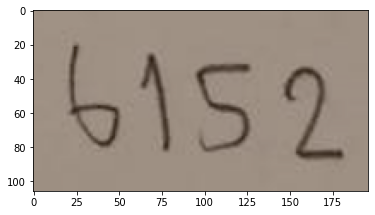

In [58]:
show_image_dataset(img)

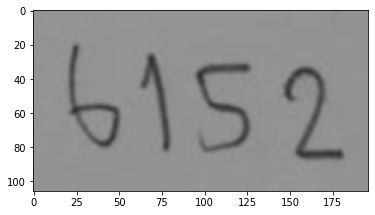

In [59]:
show_image_dataset(img_blur)

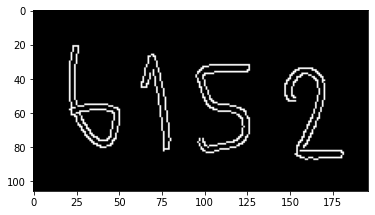

In [60]:
show_image_dataset(edges)

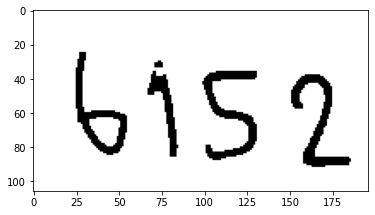

In [61]:
show_image_dataset(erosion)

In [62]:
# Preprocess using OTSU thresold
blur = cv2.GaussianBlur(test_data,(5,5),0)
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Remove background using OTSU threshold
threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

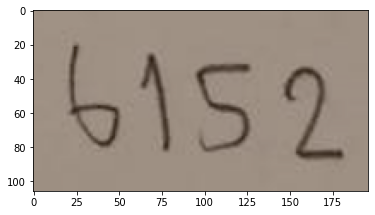

In [63]:
show_image_dataset(test_data)

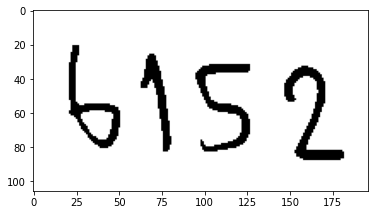

In [64]:
show_image_dataset(threshrgb)

In [65]:
# Preprocess using adaptive thresold
image = superai_images[70]
blur = cv2.GaussianBlur(image,(5,5),0)

img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Remove background using OTSU threshold
# thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

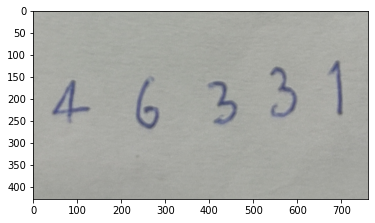

In [66]:
show_image_dataset(image)

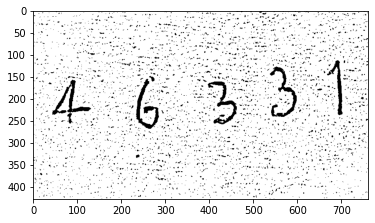

In [67]:
show_image_dataset(threshrgb)

In [68]:
# Preprocess using OTSU Thresolding
images_white = []
for image in tqdm(superai_images):
  if image is not None:
    blur = cv2.GaussianBlur(image,(5,5),0)
    img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    ret2, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    
    images_white.append(threshrgb)
  else:
    images_white.append(image)

images_white = np.array(images_white)

  0%|          | 0/2170 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [69]:
# Preprocess using Adaptive Gaussian Thresolding
images_white_adaptive = []
for image in tqdm(superai_images):
  if image is not None:
    blur = cv2.GaussianBlur(image,(5,5),0)
    img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # thresh = cv2.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
    threshrgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    images_white_adaptive.append(threshrgb)
  else:
    images_white_adaptive.append(image)

images_white_adaptive = np.array(images_white_adaptive)

  0%|          | 0/2170 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


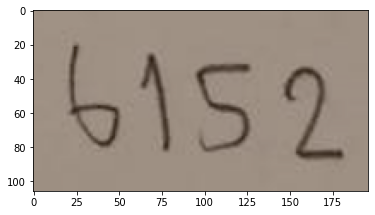

In [70]:
show_image_dataset(superai_images[0])

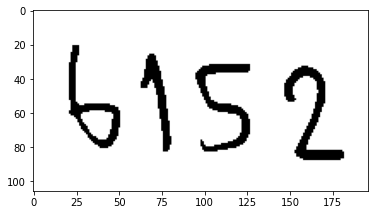

In [71]:
show_image_dataset(images_white[0])

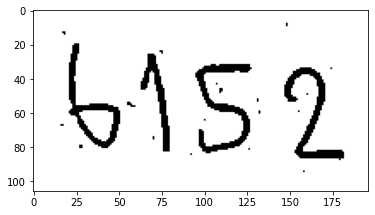

In [72]:
show_image_dataset(images_white_adaptive[0])

### Further preprocess adaptive image

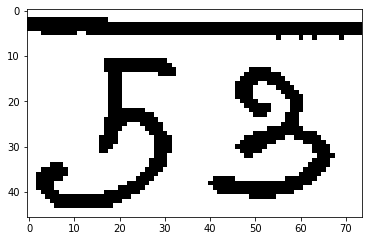

In [73]:
show_image_dataset(images_white_adaptive[19])

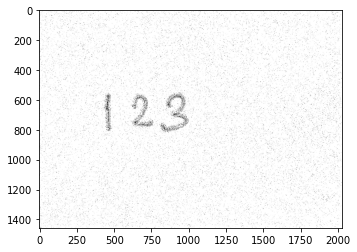

In [74]:
show_image_dataset(images_white_adaptive[8])

In [75]:
def remove_noise(img):
  #find all your connected components (white blobs in your image)
  img = cv2.bitwise_not(img)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
  #connectedComponentswithStats yields every seperated component with information on each of them, such as size
  #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
  sizes = stats[1:, -1]; nb_components = nb_components - 1

  min_size_1 = np.percentile(sizes, 95)
  max_number = -8 if len(sizes) > 8 else - len(sizes)
  min_size_2 = np.sort(sizes)[max_number]

  min_size = min(min_size_1, min_size_2)

  #your answer image
  img2 = np.zeros((output.shape))
  #for every component in the image, you keep it only if it's above min_size
  for i in range(0, nb_components):
      if sizes[i] >= min_size:
          img2[output == i + 1] = 255

  img2 = (255-img2)
  img_float32 = np.float32(img2)
  img2 = cv2.cvtColor(img_float32, cv2.COLOR_GRAY2RGB)
  img2 = img2.astype(np.uint8)
  return img2 

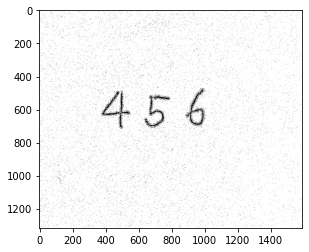

In [76]:
show_image_dataset(images_white_adaptive[11])

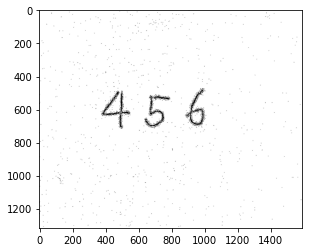

In [77]:
result = remove_noise(images_white_adaptive[11])
show_image_dataset(result)

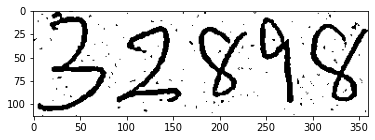

In [78]:
show_image_dataset(images_white_adaptive[10])

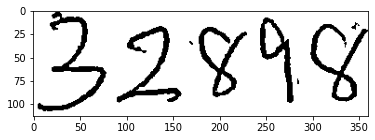

In [79]:
result = remove_noise(images_white_adaptive[10])
show_image_dataset(result)

In [80]:
images_white_denoised = []
for image in tqdm(images_white_adaptive):
  if image is not None:
    result = remove_noise(image)
    
    images_white_denoised.append(result)
  else:
    images_white_denoised.append(image)

images_white_denoised = np.array(images_white_denoised)

  0%|          | 0/2170 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


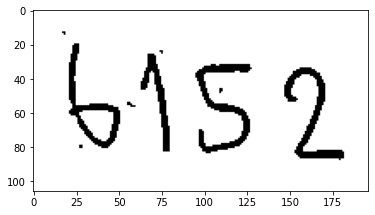

In [81]:
show_image_dataset(images_white_denoised[0])

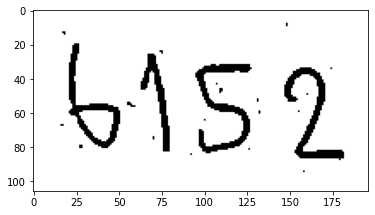

In [82]:
show_image_dataset(images_white_adaptive[0])

### Export preprocess

#### Export white OTSU

In [83]:
# for i in range(len(images_white)):
#   image = images_white[i]
#   if image is not None:
#     path = img_paths_read[i]
#     cv2.imwrite(f'drive/MyDrive/SmallTest-processed/{path}.jpg', image) 

#### Export white adaptive

In [84]:
# for i in range(len(images_white_adaptive)):
#   image = images_white_adaptive[i]
#   if image is not None:
#     path = img_paths_read[i]
#     cv2.imwrite(f'drive/MyDrive/SmallTest-processed-adaptive/{path}.jpg', image) 

#### Export denoised

In [85]:
# for i in range(len(images_white_denoised)):
#   image = images_white_denoised[i]
#   if image is not None:
#     path = img_paths_read[i]
#     cv2.imwrite(f'drive/MyDrive/SmallTest-processed-denoised/{path}.jpg', image) 

## Evaluate pretrained model

### Method used on the hackathon presentation
1. Use raw images
2. Predict images that first predicted as empty string again with `get_text_transformeres_numeric_empty_text`

In [138]:
def get_text_transformeres_numeric_empty_text(image):
  """
  Some images' prediction result is empty string via normal method: get_text_transformers(image) -> filter_nummber(text), we can imply that image is too small.
  We can use this function to predict image again to model's accuracy
  Procedure: Upsize -> Grayscale -> Thresold OTSU -> Convert to RGB -> Predict with number only TrOCR model -> filter number (basically remove spaces from result)
  """
  image = cv2.resize(image, (image.shape[1] * 2, image.shape[0] * 2))
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Remove background using OTSU threshold
  image = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

  pred_text = get_text_transformeres_numeric(image, numberic_index)

  pred_text_clean = filter_number(pred_text)
  return pred_text_clean


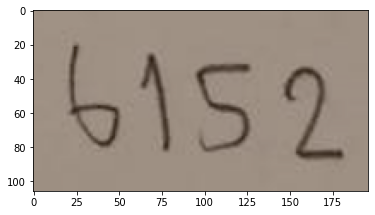

In [192]:
show_image_dataset(superai_images[0])

In [193]:
get_text_transformeres_numeric_empty_text(superai_images[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'6152'

In [194]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(superai_images[:500]))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    if len(pred_text_clean) == 0:
      empty_indexes.append(i)
      pred_text_clean = get_text_transformeres_numeric_empty_text(image)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [195]:
sum(result_distances) / len(result_distances)

0.782

Example of images that model predicted as empty string. Most of it all small sized images. The index of that images are stored in `empty_indexes`

In [196]:
empty_indexes

[14,
 29,
 46,
 50,
 55,
 93,
 95,
 97,
 100,
 116,
 132,
 137,
 139,
 145,
 158,
 182,
 187,
 192,
 198,
 201,
 204,
 218,
 230,
 235,
 245,
 264,
 275,
 285,
 289,
 292,
 297,
 362,
 372,
 381,
 400,
 407,
 408,
 427,
 433,
 435,
 436,
 441,
 449,
 458,
 465,
 477,
 491]

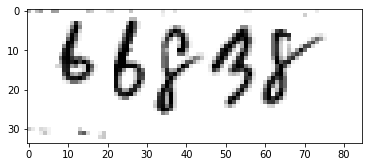

In [197]:
show_image_dataset(superai_images[empty_indexes][0])

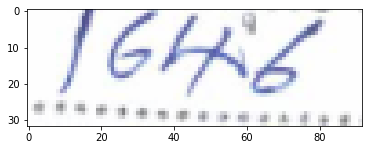

In [198]:
show_image_dataset(superai_images[empty_indexes][1])

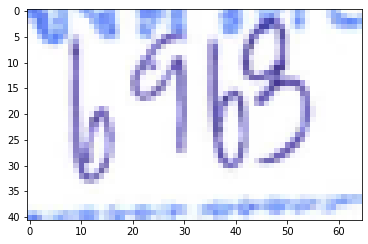

In [199]:
show_image_dataset(superai_images[empty_indexes][2])

In [200]:
"""Evaluate hard to predict images with `get_text_transformeres_numeric_empty_text`"""
di_total = 0
for i in tqdm(empty_indexes[:200]):
  image = superai_images[i]
  pred_text_clean = get_text_transformeres_numeric_empty_text(image)
  label = superai_labels[i]
  label = label if str(label) != 'nan' else ''
  result_distance = distance(pred_text_clean, label)
  di_total += result_distance
  

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [201]:
di_total / len(empty_indexes[:200])

3.106382978723404

In [202]:
"""Evaluate hard to predict images with `normal procedure`"""
di_total = 0
for i in tqdm(empty_indexes[:200]):
  image = superai_images[i]
  pred_text = get_text_transformeres(image)
  pred_text_clean = filter_number(pred_text)
  label = superai_labels[i]
  label = label if str(label) != 'nan' else ''
  result_distance = distance(pred_text_clean, label)
  di_total += result_distance
  

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [203]:
di_total / len(empty_indexes[:200])

3.4893617021276597

### Proprocessed images with OTSU thresold

In [204]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white[:500]))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [205]:
sum(result_distances) / len(result_distances)

0.818

### Preprocessed images with Adaptive thresold

In [206]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white_adaptive[:500]))):
  image = images_white_adaptive[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [207]:
sum(result_distances) / len(result_distances)

1.306

### Preprocessed images with Adaptive thresold + Denoised

In [208]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white_denoised[:500]))):
  image = images_white_denoised[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [209]:
sum(result_distances) / len(result_distances)

1.154

## Train transformers model with ORAND datasets

In [86]:
images_train_dataset = list(filter(lambda x: x is not None, orand_images))

In [87]:
len(images_train_dataset)

3784

In [88]:
images_train_label_dataset = list(filter(lambda x: str(x) != 'nan', orand_labels))

In [89]:
images_train_label_dataset[0]

'1500'

In [90]:
# images_white_train, images_white_test, superai_labels_train, superai_labels_test = train_test_split(images_train_dataset, images_train_label_dataset, test_size = 0.8, random_state = 2)
images_white_train, images_white_test, superai_labels_train, superai_labels_test = train_test_split(images_train_dataset, images_train_label_dataset, test_size = 0.8, random_state = 20)

In [91]:
len(images_white_train)

756

In [92]:
images_white_test = list(filter(lambda x: x is not None, superai_images))
superai_labels_test = list(filter(lambda x: str(x) != 'nan', superai_labels))

In [93]:
len(superai_labels_test)

870

In [94]:
len(superai_labels_test)

870

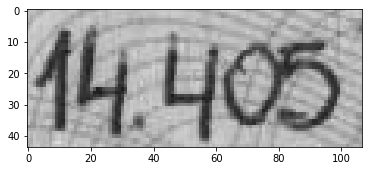

In [95]:
show_image_dataset(images_train_dataset[110])

In [96]:
images_train_label_dataset[110]

'14405'

In [97]:
import imgaug
print(imgaug.__version__)

0.2.9


In [98]:
# from imgaug import augmenters as iaa
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(4)

seq = iaa.Sequential([
    iaa.Affine(rotate=(-5, 5)),
    iaa.AdditiveGaussianNoise(scale=(10, 30)),
    iaa.GammaContrast((0.7, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
    iaa.Crop(percent=(0, 0.05))
])

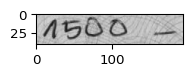

Augmented:


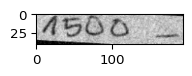

In [99]:
image = image=images_train_dataset[0]
image_aug = seq(image=image)

ia.imshow(image)
print("Augmented:")
ia.imshow(image_aug)

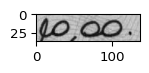

Augmented:


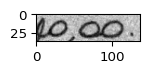

In [100]:
image = image=images_train_dataset[3]
image_aug = seq(image=image)

ia.imshow(image)
print("Augmented:")
ia.imshow(image_aug)

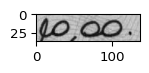

Augmented:


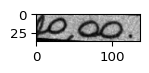

In [101]:
image = image=images_train_dataset[3]
image_aug = seq(image=image)

ia.imshow(image)
print("Augmented:")
ia.imshow(image_aug)

In [102]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class DigitSequenceDataset(Dataset):
    def __init__(self, texts, images, processor, max_target_length=16):
        self.texts = texts
        self.images = images
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        
        text = self.texts[idx]
        image = self.images[idx]
        
        image_aug = seq(image=image)

        pixel_values = self.processor(image_aug, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [103]:
"""
DigitSequenceDatasetTest has no data augmentation code
"""
import torch
from torch.utils.data import Dataset
from PIL import Image

class DigitSequenceDatasetTest(Dataset):
    def __init__(self, texts, images, processor, max_target_length=16):
        self.texts = texts
        self.images = images
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        
        text = self.texts[idx]
        image = self.images[idx]
        

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

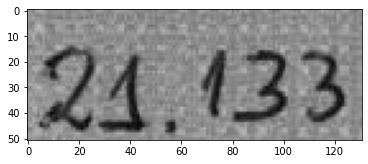

In [104]:
show_image_dataset(images_white_train[100])

In [105]:
superai_labels_train[100]

'21133'

In [106]:
from transformers import TrOCRProcessor

train_dataset = DigitSequenceDataset(images=images_white_train,
                           texts=superai_labels_train,
                           processor=processor)
eval_dataset = DigitSequenceDatasetTest(images=images_white_test,
                           texts=superai_labels_test,
                           processor=processor)

In [107]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 756
Number of validation examples: 870


In [108]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([16])


In [109]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

883


In [110]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 16
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [111]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    num_train_epochs=3,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [112]:
def array_distance(arr1, arr2):
  if len(arr1) != len(arr2):
    raise Error('Array errors')
  total_distance = 0
  for i in range(len(arr1)):
    total_distance += distance(arr1[i], arr2[i])

  return total_distance / len(arr1)

In [113]:
array_distance(['11', '11'], ['122', '12'])

1.5

In [114]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    # cer = cer_metric.compute(predictions=pred_str, references=label_str)
    edit_distance = array_distance(pred_str, label_str)

    return {"edit_distance": edit_distance}

In [115]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using amp half precision backend
***** Running training *****
  Num examples = 756
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 285


Step,Training Loss,Validation Loss,Edit Distance
200,0.028000,0.511332,0.329885


***** Running Evaluation *****
  Num examples = 870
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=285, training_loss=0.6309041208996061, metrics={'train_runtime': 351.7383, 'train_samples_per_second': 6.448, 'train_steps_per_second': 0.81, 'total_flos': 1.6971108131788554e+18, 'train_loss': 0.6309041208996061, 'epoch': 3.0})

In [116]:
""" Uncomment and run this code if you want to free up memory of huggingface model """

# import gc

# model.cpu()
# del model
# del trainer
# gc.collect()
# torch.cuda.empty_cache()

' Uncomment and run this code if you want to free up memory of huggingface model '

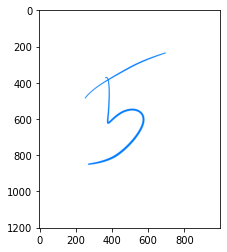

In [117]:
show_image_dataset(images_white_test[28])

In [118]:
# images_white_ardis_train, images_white_ardis_test, images_white_ardis_label_train, images_white_ardis_label_test
pixel_values = processor(images_white_test[28], return_tensors="pt").pixel_values

pixel_values_tensor = torch.tensor(pixel_values).cuda()

generated_ids = model.generate(pixel_values_tensor)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


'35'

In [119]:
superai_labels_test[28]

'5'

In [120]:
"""Evaluate distance without filter_number"""
distance_list = []
for i in tqdm(range(len(images_white_test[:500]))):
  pixel_values = processor(images_white_test[i], return_tensors="pt").pixel_values

  pixel_values_tensor = torch.tensor(pixel_values).cuda()

  generated_ids = model.generate(pixel_values_tensor)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  label = superai_labels_test[i]
  distance_list.append(distance(generated_text, label))

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


##### Note: turns out the best method we tried so far is no proprocess without `filter_number` NOT the method presented in the hackathon pitching. Due to time constraint, we did not notice this on the presentation day!

In [121]:
sum(distance_list) / len(distance_list)

0.256

In [122]:
"""Evaluate distance with filter_number"""
distance_list = []
predicted_texts = []
for i in tqdm(range(len(images_white_test[:500]))):
  pixel_values = processor(images_white_test[i], return_tensors="pt").pixel_values

  pixel_values_tensor = torch.tensor(pixel_values).cuda()

  generated_ids = model.generate(pixel_values_tensor)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  predicted_text = filter_number(generated_text)
  label = superai_labels_test[i]
  

  predicted_texts.append(predicted_text)
  distance_list.append(distance(predicted_text, label))

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [123]:
sum(distance_list) / len(distance_list)

0.278

In [124]:
# model.save_pretrained('./model')

## Evaluate finetuned model

### Proprocessed images with OTSU thresold

In [125]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white[:500]))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [126]:
sum(result_distances) / len(result_distances)

0.272

### Preprocessed images with Adaptive thresold

In [127]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white_adaptive[:500]))):
  image = images_white_adaptive[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [128]:
sum(result_distances) / len(result_distances)

0.398

### Preprocessed images with Adaptive thresold + Denoised

In [129]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(images_white_denoised[:500]))):
  image = images_white_denoised[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [130]:
sum(result_distances) / len(result_distances)

0.4

### Method used on the hackathon presentation
1. Use raw images
2. Predict images that first predicted as empty string again with `get_text_transformeres_numeric_empty_text`

In [131]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(superai_images[:500]))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    if len(pred_text_clean) == 0:
      empty_indexes.append(i)
      pred_text_clean = get_text_transformeres_numeric_empty_text(image)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [132]:
sum(result_distances) / len(result_distances)

0.27

In [133]:
model.config.num_beams = 1 # Set beam search back to one to compatible with `get_text_transformeres_numeric_empty_text`

In [134]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(superai_images[:500]))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    if len(pred_text_clean) == 0:
      empty_indexes.append(i)
      pred_text_clean = get_text_transformeres_numeric_empty_text(image)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [135]:
sum(result_distances) / len(result_distances)

0.266

##### The finetuned model performed so well that we don't need sophisticated pipeline as presented in the hackathon. As we can see that indexes of the image that model predicted as empty string is empty/almost empty

In [136]:
empty_indexes

[]

## Export prediction result to CSV

In [139]:
"""Try with raw images"""
result_distances = []
pred_texts = []
pred_text_cleans = []

empty_indexes = []

for i in tqdm(range(len(superai_images))):
  image = superai_images[i]
  if image is None:
    pred_texts.append('')
    pred_text_cleans.append('')
  else:
    pred_text = get_text_transformeres(image)
    pred_text_clean = filter_number(pred_text)
    if len(pred_text_clean) == 0:
      empty_indexes.append(i)
      pred_text_clean = get_text_transformeres_numeric_empty_text(image)
    label = superai_labels[i]
    label = label if str(label) != 'nan' else ''
    
    result_distance = distance(pred_text_clean, label)
    
    result_distances.append(result_distance)
    pred_texts.append(pred_text)
    pred_text_cleans.append(pred_text_clean)

  0%|          | 0/2170 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [140]:
csv

,Id,Predicted,label
0,1a4545ae6128dab578f90fb22b55758a,6152.0,6152
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917.0,87917
2,e297ec8d07a7b8b96c4ae16236d3b442,2462.0,2462
3,f34c7b3405df590f88d4cf7b046ebed6,38714.0,38714
4,629ab866836150706a45ee0e9108697a,16.0,1674
...,...,...,...
2165,317aa1f54519e65ce1e3855346e7bad4,NaN,NaN
2166,b5a3b8d297a574e4406bd11fd5b6ec24,NaN,NaN
2167,399434b91e74cb5211c5ea1a301f431a,NaN,NaN
2168,17c2c6feeea11a7779d21e6f99b7b714,NaN,NaN


In [141]:
csv['Predicted'] = pd.Series(pred_text_cleans, dtype="string")

In [142]:
submission_csv = csv.drop(['label'], axis = 1)

In [143]:
submission_csv.head(50)

,Id,Predicted
0,1a4545ae6128dab578f90fb22b55758a,6152
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917
2,e297ec8d07a7b8b96c4ae16236d3b442,2462
3,f34c7b3405df590f88d4cf7b046ebed6,38714
4,629ab866836150706a45ee0e9108697a,1674
5,e9354283b9347e71986d122546c029f0,51236
6,d0e04d5459f95a125099dacc72e9ea01,2796
7,f620c24a7a3a519d91391d6dbb34bc7d,999
8,815f592afe9145ae0804d692094e5f5b,123
9,ad97c105d62dd6bac2ce2aeb14eed4e5,06090


In [144]:
submission_csv

,Id,Predicted
0,1a4545ae6128dab578f90fb22b55758a,6152
1,1bc5d2ff9a7e9fdbff5f2f68f42ff64e,87917
2,e297ec8d07a7b8b96c4ae16236d3b442,2462
3,f34c7b3405df590f88d4cf7b046ebed6,38714
4,629ab866836150706a45ee0e9108697a,1674
...,...,...
2165,317aa1f54519e65ce1e3855346e7bad4,2223
2166,b5a3b8d297a574e4406bd11fd5b6ec24,6332
2167,399434b91e74cb5211c5ea1a301f431a,1993
2168,17c2c6feeea11a7779d21e6f99b7b714,676


In [145]:
submission_csv.to_csv('sample_submission.csv', index=False)

In [146]:
## Private score: 0.33364 on Kaggle